<a href="https://colab.research.google.com/github/misbah4064/age_and_gender_detection/blob/master/age%26genderDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/misbah4064/age_and_gender_detection.git
%cd age_and_gender_detection

Cloning into 'age_and_gender_detection'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
/content/age_and_gender_detection


In [2]:
# Downloading pretrained data and unzipping it
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
# https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
!unzip modelNweight.zip

Downloading...
From: https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
To: /content/age_and_gender_detection/modelNweight.zip
86.2MB [00:00, 237MB/s]
Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


In [3]:
# Import required modules
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow
# import argparse

def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"

ageProto = "modelNweight/age_deploy.prototxt"
ageModel = "modelNweight/age_net.caffemodel"

genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        # print("Gender Output : {}".format(genderPreds))
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

Gender : Male, conf = 1.000
Age Output : [[8.4598862e-05 2.8288080e-03 3.9837560e-01 7.8673773e-03 5.8918923e-01
  1.3369536e-03 2.7226479e-04 4.5179015e-05]]
Age : (25-32), conf = 0.589


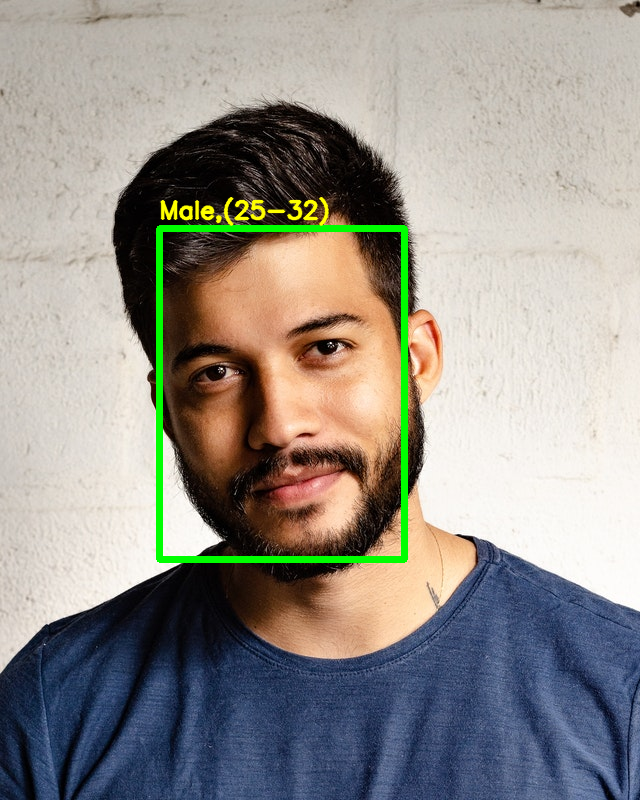

In [11]:
input = cv.imread("image.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

Gender : Male, conf = 1.000
Age Output : [[7.0540409e-07 3.7358452e-05 2.0373709e-02 1.6500556e-03 9.7762191e-01
  3.0096577e-04 6.1849919e-06 9.2617784e-06]]
Age : (25-32), conf = 0.978


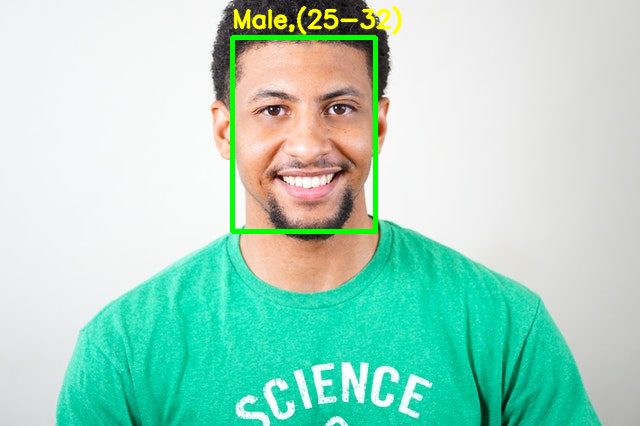

In [12]:
input = cv.imread("image1.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

Gender : Male, conf = 1.000
Age Output : [[1.9950876e-03 5.0318660e-05 8.4574794e-04 1.4283879e-04 7.5796200e-04
  1.0425225e-01 4.2547666e-02 8.4940809e-01]]
Age : (60-100), conf = 0.849


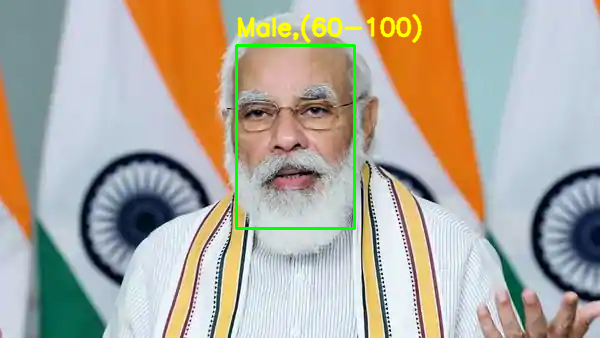

In [15]:
input = cv.imread("image2.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

In [16]:
import cv2
cap = cv2.VideoCapture('video.mp4')
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = age_gender_detector(frame)
  out.write(output)
out.release()
print("Done processing video")

Processing Video...
Gender : Male, conf = 0.991
Age Output : [[1.9485973e-04 9.9193573e-01 7.8223916e-03 1.4352014e-05 9.5806008e-06
  1.9119801e-05 2.5295024e-06 1.5240112e-06]]
Age : (4-6), conf = 0.992
Gender : Female, conf = 0.965
Age Output : [[9.54717159e-01 3.23594920e-02 1.22785373e-02 1.11674795e-04
  2.20690446e-04 1.97814603e-04 4.04391576e-05 7.43513447e-05]]
Age : (0-2), conf = 0.955
Gender : Male, conf = 0.979
Age Output : [[4.58503026e-04 9.81036663e-01 1.80823803e-02 1.30004919e-04
  1.00299607e-04 1.55990580e-04 2.52459122e-05 1.07117985e-05]]
Age : (4-6), conf = 0.981
Gender : Female, conf = 0.977
Age Output : [[8.9754087e-01 4.6496905e-02 5.3314965e-02 3.3239796e-04 1.1227333e-03
  8.3362858e-04 1.3022518e-04 2.2832594e-04]]
Age : (0-2), conf = 0.898
Gender : Male, conf = 0.996
Age Output : [[7.5695402e-04 9.7670263e-01 2.1732567e-02 2.4847430e-04 1.6005455e-04
  3.1052224e-04 6.4130130e-05 2.4523602e-05]]
Age : (4-6), conf = 0.977
Gender : Female, conf = 0.978
Age O